# Import pakcages

In [2]:
!pip install pyLDAvis

In [3]:
!pip install striprtf

In [4]:
!pip install contractions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 12.7 MB/s eta 0:00:00


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import os
import gensim
import numpy as np
import pandas as pd
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from striprtf.striprtf import rtf_to_text
import re
from collections import Counter
import matplotlib.pyplot as plt
from itertools import chain
import string
from pprint import pprint
from gensim.models.coherencemodel import CoherenceModel
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from gensim.models.phrases import Phrases, Phraser
from nltk.stem import WordNetLemmatizer
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import contractions
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
from gensim.models import LdaModel
import random
import seaborn as sns

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Testing LDA model on English Modern

# Data preprocessing

### Functions

In [7]:
def get_files(root_dir):
  # Define a list to store the text from .rtf files
  file_list = []

  # Recursively search for files in the root directory and its subdirectories
  for subdir, dirs, files in os.walk(root_dir):
      for fil in files:
          obj = {}
          file_path = os.path.join(subdir, fil)
          seg = subdir.split('/')
          obj['term'] = seg[-1]
          f = open(file_path, 'r')
          text = f.read()
          obj['text'] = text
          f.close
          file_list.append(obj)
  return file_list

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
def extract_doc (file_list):
  regex_pattern = "(.*?)Database:"
  doc_list = []
  for obj in file_list:
    matches = re.finditer(regex_pattern, obj['text'], re.DOTALL)
    for mat in matches:
      doc = {}
      extracted_text = mat.group(1).strip()
      doc['text'] = extracted_text
      doc['term'] = obj['term']
      doc_list.append(doc)
  return doc_list

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
def extract_full_text(doc_list):
  cont_list = []
  pattern0 = r"Full text:(.*?)Location:"
  pattern1 = r"document ID:(.*?)\n"
  pattern2 = r"Source type:(.*?)\n"
  pattern3 = r"Publication date:(.*?)\n"
  pattern4 = r"^.*?Subject:.*?$"
  pattern5 = r"^.*?Business indexing term:.*?$"
  subject_pattern = r"Subject:(.*?)\n"
  subject = ["NA"]
  source = "NA"
  date = "NA"
  for doc in doc_list:
    t = {}
    m0 = re.search(pattern0, doc['text'], re.DOTALL)
    cont = m0.group(1).strip()
    m1 = re.search(pattern1, doc['text'], re.DOTALL)
    id = m1.group(1).strip()
    m2 = re.search(pattern2, doc['text'], re.DOTALL)
    if m2:
      source = m2.group(1).strip()
    m3 = re.search(pattern3, doc['text'], re.DOTALL)
    if m3:
      date = m3.group(1).strip()
    m6 = re.search(subject_pattern, doc['text'], re.DOTALL)
    if m6:
      subject = m6.group(1).strip()
      subject = subject.split("; ")
    m4 = re.search(pattern4, cont, re.DOTALL)
    m5 = re.search(pattern5, cont, re.DOTALL)
    if m5:
      cont = re.sub(pattern5, "", cont, flags=re.MULTILINE)
    if m4:
      cont = re.sub(pattern4, "", cont, flags=re.MULTILINE)
    t['term'] = doc['term']
    t['full_text'] = cont
    t['date'] = date
    t['source'] = source
    t['id'] = id
    t['subject'] = subject
    file_name = source + "_" + doc['term'] + "_" + date + "_" + id
    print(file_name)
    cont_list.append(t)
  return cont_list



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
def rm_duplicates(cont_list):
  unique_data = []
  seen_texts = set()
  for entry in cont_list:
      full_text = entry['full_text'][:100]
      if full_text not in seen_texts:
          unique_data.append(entry)
          seen_texts.add(full_text)
  return unique_data

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
def remove_links(text):
    pattern = r'\( https?://[^\s()]+ \)'
    text_without_links = re.sub(pattern, '', text)
    return text_without_links

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
def rm_contractions (text_list):
  expanded_doc = [contractions.fix(text['full_text']) for text in text_list]
  return expanded_doc

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
def remove_short_and_long_words(nested_list, min_length=3, max_length=15):
    filtered_list = []

    for sublist in nested_list:
        filtered_sublist = [word for word in sublist if min_length <= len(word) <= max_length]
        filtered_list.append(filtered_sublist)

    return filtered_list

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
def text_clean_punctuation(text_list):
  cleaned_list = []
  for text in text_list:
    cleaned = text.replace('\n', ' ').replace("\\", "").replace(' - ', '-').replace('"', ' ')
    punctuation = string.punctuation.replace('-', '').replace("'",'')
    no_punctuation = cleaned.translate(str.maketrans('', '', punctuation))
    cleaned_list.append(no_punctuation)
  return cleaned_list

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
def stemming(text_list):
  stemmer = PorterStemmer()
  stemmed_documents = [[stemmer.stem(word) for word in doc] for doc in text_list]
  return stemmed_documents

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [16]:
def tokenize_rm_stopwords(text_list):
  stop_words = stopwords.words('english')
  texts = [[word for word in document.lower().split() if word not in stop_words] for document in text_list]
  return texts

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
def include_subject(unique_list, tokenized_list):
  result_list = tokenized_doc[:]
  for i in range(len(result_list)-1):
    subject = unique_list[i]['subject']
    subject = [string.lower().replace(" ", "_") for string in subject]
    result_list[i].extend(subject)
  return result_list

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
def lemmatize_doc(doc):
    lemmatizer = WordNetLemmatizer()
    lemmatized_list = []

    for sublist in doc:
        lemmatized_sublist = []
        i = 0
        for token in sublist:
          # Lemmatize nouns
          for arg in ['n', 'v', 'a', 'r']:
            token = lemmatizer.lemmatize(token, pos=arg)
          lemmatized_sublist.append(token)
        lemmatized_list.append(lemmatized_sublist)
        # for token, lemma in zip(sublist, lemmatized_sublist):
        #   if i < 10:
        #     print(f"{token} --> {lemma}")
        #   else:
        #     break
        #   i += 1
    return lemmatized_list

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:
def add_bigram(lemma_doc, min_count=10):
  bigram = Phrases(lemma_doc, min_count = min_count)
  bigram_doc = [bigram[doc] for doc in lemma_doc]
  return bigram_doc

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [20]:
def add_trigram(bigram_doc, min_count=10):
  trigram = Phrases(bigram_doc, min_count = min_count)
  trigram_doc = [trigram[doc] for doc in bigram_doc]
  return trigram_doc

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
def rm_key_term (trigram_doc, word_list):
  result = [[word for word in doc if word not in word_list]for doc in trigram_doc]
  return result

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Import data

In [22]:
root_dir = '/content/drive/MyDrive/audace_trial/corpus/english_modern'

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [23]:
file_list = get_files(root_dir)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Data cleaning

In [24]:
doc_list = extract_doc(file_list)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [25]:
cont_list = extract_full_text(doc_list)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Blog, Podcast, or W ebsite_flood_Sep 29, 2020_2447104249
Wire Feed_flood_Sep 28, 2020_2447365132
Blog, Podcast, or W ebsite_flood_Sep 28, 2020_2447063451
Blog, Podcast, or W ebsite_flood_Sep 28, 2020_2447062092
Blog, Podcast, or Website_flood_May 14, 2020_2402597693
Blog, Podcast, or Website_flood_May 8, 2020_2400120923
Blog, Podcast, or Website_flood_Apr 3, 2020_2385834748
Blog, Podcast, or Website_flood_Apr 2, 2020_2385831916
Blog, Podcast, or Website_flood_Apr 2, 2020_2385821376
Blog, Podcast, or Website_flood_Apr 2, 2020_2385757794
Blog, Podcast, or Website_flood_Mar 28, 2020_2383923470
Blog, Podcast, or Website_flood_Mar 13, 2020_2376983539
Newspaper_flood_Feb 12, 2020_2353875312
Blog, Podcast, or Website_flood_Feb 12, 2020_2353761600
Blog, Podcast, or Website_flood_Feb 11, 2020_2353746300
Newspaper_flood_Feb 6, 2020_2351863810
Newspaper_flood_Feb 1, 2020_2349709274
Blog, Podcast, or Website_flood_Jan 31, 2020_2349784146
Blog, Podcast, or Website_flood_Nov 1, 2019_2311264289
Blog,

In [26]:
len(cont_list)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2737

In [27]:
unique_list = rm_duplicates(cont_list)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [28]:
len(unique_list)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


1559

In [29]:
exp_list = rm_contractions(unique_list)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [30]:
cleaned_content = text_clean_punctuation(exp_list)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [31]:
tokenized_doc = tokenize_rm_stopwords(cleaned_content)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [33]:
new_tokenized_doc = include_subject(unique_list, tokenized_doc)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [35]:
filtered_doc = remove_short_and_long_words(new_tokenized_doc)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [36]:
lemma_doc = lemmatize_doc(filtered_doc)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [37]:
# keywords = ['flood', 'blizzard', 'snow', 'heat_wave', 'rain', 'fire', 'heat', 'wave']
# lemma_doc = rm_key_term(lemma_doc, keywords)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [38]:
bigram_doc = add_bigram(lemma_doc, 5)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [39]:
trigram_doc = add_trigram(bigram_doc, 5)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


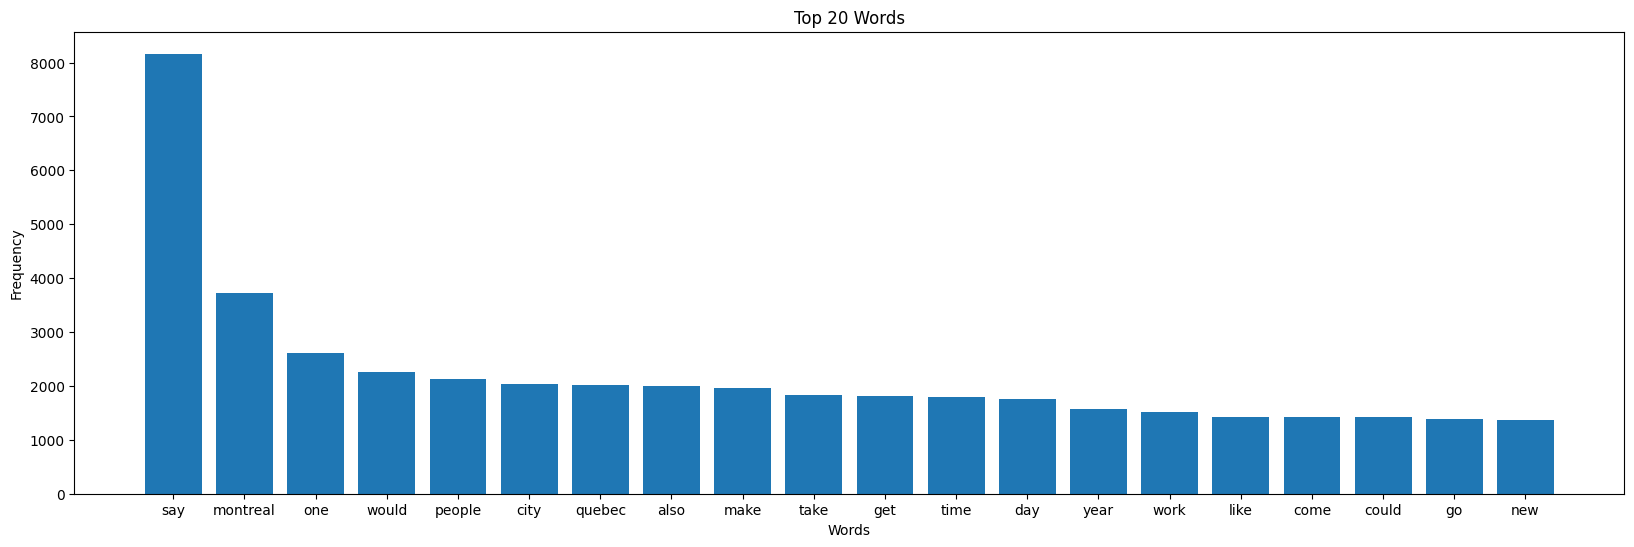

In [40]:
words = trigram_doc

flat_words = list(chain.from_iterable(words))

word_counts = Counter(flat_words)

top_words = word_counts.most_common(20)

labels, values = zip(*top_words)
plt.figure(figsize=(20, 6))
plt.bar(labels, values)
plt.title("Top 20 Words")
plt.xlabel("Words")
plt.ylabel("Frequency")

plt.show()

## Create corpus and dictionary

In [102]:
# Create dictionary and corpus
texts = trigram_doc
dictionary = gensim.corpora.Dictionary(texts)
dictionary.filter_extremes(no_below=10, no_above=0.6)
corpus = [dictionary.doc2bow(text) for text in texts]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [104]:
dictionary.save('/content/drive/MyDrive/audace_trial/model/dictionary/dictionary_2023-07-03_filter_10_06.dict')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [103]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 6843
Number of documents: 1559


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Genism LDA model

## Select number of topics: K

In [97]:
chunksize = 2200
passes = 15
iterations = 400
eval_every = None

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [98]:
max_num = 50

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### cv coherence score

In [ ]:
coherence_scores_cv = []
for i in range(1, max_num):
  lda_model = gensim.models.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=i,
    chunksize = chunksize,
    iterations = iterations,
    passes = passes,
    alpha = 'auto',
    eta = 'auto',
    eval_every = eval_every
    )
  # top_topics = lda_model.top_topics(corpus)
  coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, corpus=corpus, dictionary=dictionary, coherence='c_v', window_size = 110)
  coherence_lda = coherence_model_lda.get_coherence()
  print('number of topics: ', i)
  print('nCoherence Score: ', coherence_lda)
  coherence_scores_cv.append(coherence_lda)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


number of topics:  1
nCoherence Score:  0.276163800607361
number of topics:  2
nCoherence Score:  0.2893734872371512
number of topics:  3
nCoherence Score:  0.3442757678215758
number of topics:  4
nCoherence Score:  0.32816564205058896


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


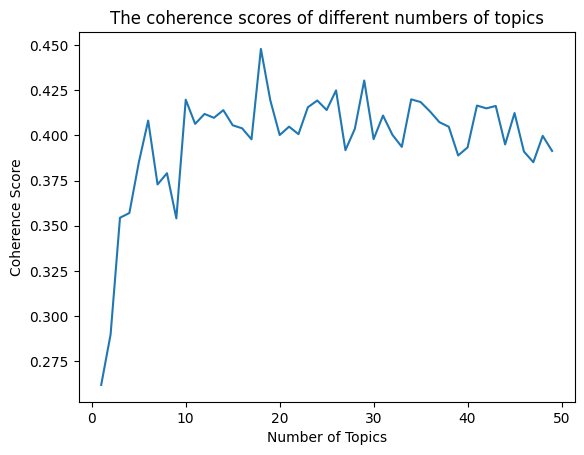

In [ ]:
plt.plot(range(1,max_num), coherence_scores_cv)
plt.title("The coherence scores of different numbers of topics")
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.show
plt.savefig("LDA_coherence_cv_scores.png")

### umass coherence score

In [ ]:
coherence_scores_umass = []
for i in range(1, max_num):
  lda_model = gensim.models.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=i,
    chunksize = chunksize,
    iterations = iterations,
    passes = passes,
    alpha = 'auto',
    eta = 'auto',
    eval_every = eval_every
    )
  # top_topics = lda_model.top_topics(corpus)
  coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, corpus=corpus, dictionary=dictionary, coherence='u_mass')
  coherence_lda = coherence_model_lda.get_coherence()
  print('number of topics: ', i)
  print('nCoherence Score: ', coherence_lda)
  coherence_scores_umass.append(coherence_lda)

In [ ]:
plt.plot(range(1,max_num), coherence_scores_umass)
plt.title("The umass coherence scores of different numbers of topics")
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.show
plt.savefig("LDA_coherence_umass_scores.png")

### c_uci coherence score

In [ ]:
coherence_scores_cuci = []
for i in range(1, max_num):
  lda_model = gensim.models.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=i,
    chunksize = chunksize,
    iterations = iterations,
    passes = passes,
    alpha = 'auto',
    eta = 'auto',
    eval_every = eval_every
    )
  # top_topics = lda_model.top_topics(corpus)
  coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, corpus=corpus, dictionary=dictionary, coherence='c_uci')
  coherence_lda = coherence_model_lda.get_coherence()
  print('number of topics: ', i)
  print('nCoherence Score: ', coherence_lda)
  coherence_scores_cuci.append(coherence_lda)

In [ ]:
plt.plot(range(1,max_num), coherence_scores_cuci)
plt.title("The cuci coherence scores of different numbers of topics")
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.show
plt.savefig("LDA_coherence_cuci_scores.png")

### c_npmi coherence score

In [ ]:
coherence_scores_cnpmi = []
for i in range(1, max_num):
  lda_model = gensim.models.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=i,
    chunksize = chunksize,
    iterations = iterations,
    passes = passes,
    alpha = 'auto',
    eta = 'auto',
    eval_every = eval_every
    )
  # top_topics = lda_model.top_topics(corpus)
  coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, corpus=corpus, dictionary=dictionary, coherence='c_npmi')
  coherence_lda = coherence_model_lda.get_coherence()
  print('number of topics: ', i)
  print('nCoherence Score: ', coherence_lda)
  coherence_scores_cnpmi.append(coherence_lda)

In [ ]:
plt.plot(range(1,max_num), coherence_scores_cnpmi)
plt.title("The cnpmi coherence scores of different numbers of topics")
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.show
plt.savefig("LDA_coherence_cnpmi_scores.png")

### select k

In [ ]:
k = coherence_scores_cv.index(max(coherence_scores_cv))+1

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
k

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


14

## Training

In [ ]:
num_topics = k
chunksize = 2200
passes = 15
iterations = 400
eval_every = None

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 3578
Number of documents: 1559


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
lda_model = gensim.models.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    alpha = 'auto',
    eta = 'auto',
    chunksize=chunksize,
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
    )

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, corpus=corpus, dictionary=dictionary, coherence='c_v', window_size = 110)
coherence_lda = coherence_model_lda.get_coherence()
print("The score is ", coherence_lda)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


The score is  0.43663332505445773


In [ ]:
while coherence_lda < 0.45:
  lda_model = gensim.models.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    alpha = 'auto',
    eta = 'auto',
    chunksize=chunksize,
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
    )
  coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, corpus=corpus, dictionary=dictionary, coherence='c_v', window_size = 110)
  coherence_lda = coherence_model_lda.get_coherence()
  print("The score is ", coherence_lda)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


The score is  0.41973416067574715
The score is  0.40691519715878877
The score is  0.41608470731842256
The score is  0.4001718315757656
The score is  0.4292527667318413
The score is  0.4157068575463422
The score is  0.3814421690058307
The score is  0.36897089418774354
The score is  0.40385169564961254
The score is  0.3824317103194212
The score is  0.4106444632927739
The score is  0.4205938894973802
The score is  0.4322632958409841
The score is  0.43473874652597716
The score is  0.41441277275770205
The score is  0.43374589018836474
The score is  0.42817808716839045
The score is  0.38034629772602746
The score is  0.4208061644317006
The score is  0.41906998773324133
The score is  0.41358158331721345
The score is  0.3750646213684977
The score is  0.4434539548323668
The score is  0.39877101114998303
The score is  0.42594541673679864
The score is  0.38821249390119295
The score is  0.36065488963498493
The score is  0.4045907091074576
The score is  0.39068089927940597
The score is  0.4184899879

In [ ]:
top_topics = lda_model.top_topics(corpus)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / k
print('Average topic coherence: %.4f.' % avg_topic_coherence)

from pprint import pprint
pprint(top_topics)

Average topic coherence: -1.3187.
[([(0.01093439, 'people'),
   (0.010246698, 'school'),
   (0.007331095, 'student'),
   (0.0064823558, 'parent'),
   (0.0060907886, 'city'),
   (0.005914339, 'need'),
   (0.005828082, 'plan'),
   (0.005582332, 'child'),
   (0.0054622013, 'new'),
   (0.00519852, 'march'),
   (0.0047950214, 'work'),
   (0.00479148, 'help'),
   (0.0047644996, 'many'),
   (0.0046735923, 'think'),
   (0.0045276713, 'could'),
   (0.0044710846, 'want'),
   (0.0040458394, 'quebec'),
   (0.0037913767, 'get'),
   (0.0037857406, 'part'),
   (0.0036927345, 'come')],
  -0.7535264026055415),
 ([(0.007223269, 'get'),
   (0.0066845883, 'like'),
   (0.0063324915, 'know'),
   (0.005854696, 'show'),
   (0.005663458, 'go'),
   (0.0053796363, 'come'),
   (0.0053494466, 'year'),
   (0.0047858274, 'think'),
   (0.0046569454, 'life'),
   (0.004575281, 'play'),
   (0.004438607, 'write'),
   (0.0042121913, 'people'),
   (0.0041601057, 'work'),
   (0.004143205, 'canadian'),
   (0.0040673064, 'boo

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(0.00364134, 'price'),
   (0.0035297193, 'sell'),
   (0.0034963589, 'city'),
   (0.0034857553, 'million'),
   (0.003351495, 'sale'),
   (0.0033504989, 'toronto')],
  -1.2190273013306714),
 ([(0.020415924, 'canadiens'),
   (0.018684354, 'game'),
   (0.013815469, 'play'),
   (0.012050118, 'team'),
   (0.010461197, 'season'),
   (0.007815839, 'win'),
   (0.007766481, 'player'),
   (0.007219901, 'get'),
   (0.007096367, 'goal'),
   (0.0067649498, 'first'),
   (0.0064187716, 'hockey'),
   (0.005928292, 'best'),
   (0.005798307, 'two'),
   (0.005706846, 'good'),
   (0.0055297883, 'go'),
   (0.0053447043, 'shoot'),
   (0.005335551, 'nhl'),
   (0.004964717, 'score'),
   (0.0047959937, 'habs'),
   (0.004616565, 'ice')],
  -1.2286572128753406),
 ([(0.022415807, 'flood'),
   (0.017308045, 'city'),
   (0.010757579, 'home'),
   (0.008093965, 'people'),
   (0.007017228, 'resident'),
   (0.006813742, 'water'),
   (0.006800847, 'fire'),
   (0.005764551, 'area'),
   (0.005681423, 'work'),
   (0.0052010

In [ ]:
# get the topic-term matrix
topic_terms = lda_model.get_topics()

# number of top words to consider for each topic
topn = 10

# print top words for each topic and assign a label
for i in range(lda_model.num_topics):
    topic_terms_sorted = sorted(enumerate(topic_terms[i]), key=lambda x: x[1], reverse=True)[:topn]
    top_words = [dictionary[id] for id, _ in topic_terms_sorted]
    print(f"Topic {i+1}: {', '.join(top_words)}")

Topic 1: rain, expect, area, storm, weather, temperature, region, could, forecast, wind
Topic 2: call, highway, quebec, thursday, city, friday, expect, include, report, monday
Topic 3: people, school, student, parent, city, need, plan, child, new, march
Topic 4: get, like, know, show, go, come, year, think, life, play
Topic 5: company, business, new, build, market, canada, per_cent, canadian, work, cost
Topic 6: heat_wave, city, per_cent, heat, people, temperature, full_story, expect, cool, average
Topic 7: canadiens, game, play, team, season, win, player, get, goal, first
Topic 8: flood, city, home, people, resident, water, fire, area, work, year
Topic 9: quebec, group, people, member, canada, case, show, new, race, call
Topic 10: snow, winter, get, weather, car, city, cold, ski, ice, season
Topic 11: like, restaurant, include, new, food, open, get, park, light, use
Topic 12: park, city, bike, mountain, snow, walk, winter, part, path, use
Topic 13: quebec, liberal, party, vote, govern

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
topic_keywords = lda_model.show_topics(num_topics=-1, num_words=20)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
for topic in topic_keywords:
    print(f"Topic {topic[0]}: {topic[1]}")

Topic 0: 0.019*"rain" + 0.016*"expect" + 0.014*"area" + 0.012*"storm" + 0.012*"weather" + 0.011*"temperature" + 0.010*"region" + 0.010*"could" + 0.010*"forecast" + 0.009*"wind" + 0.008*"quebec" + 0.008*"warn" + 0.008*"friday" + 0.008*"freeze_rain" + 0.007*"environment_canada" + 0.007*"saturday" + 0.007*"sunday" + 0.006*"affect" + 0.006*"power" + 0.006*"even"
Topic 1: 0.012*"call" + 0.011*"highway" + 0.010*"quebec" + 0.008*"thursday" + 0.008*"city" + 0.007*"friday" + 0.007*"expect" + 0.007*"include" + 0.007*"report" + 0.006*"monday" + 0.006*"snow" + 0.005*"begin" + 0.005*"freeze_rain" + 0.005*"tuesday" + 0.004*"wednesday" + 0.004*"service" + 0.004*"rain" + 0.004*"receive" + 0.004*"ave" + 0.004*"close"
Topic 2: 0.011*"people" + 0.010*"school" + 0.007*"student" + 0.006*"parent" + 0.006*"city" + 0.006*"need" + 0.006*"plan" + 0.006*"child" + 0.005*"new" + 0.005*"march" + 0.005*"work" + 0.005*"help" + 0.005*"many" + 0.005*"think" + 0.005*"could" + 0.004*"want" + 0.004*"quebec" + 0.004*"get" 

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
vis_data = gensimvis.prepare(lda_model, corpus, dictionary,  mds='mmds')
pyLDAvis.display(vis_data)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


In [ ]:
pyLDAvis.save_html(vis_data, 'lda_' + str(k) + 'topics.html')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Save model

In [ ]:
lda_model.save("/content/drive/MyDrive/audace_trial/model/lda_models/lda_model_include_subject_0.4509_07_02.lda")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Pretrained LDA model

# Classification


In [43]:
model = LdaModel.load("/content/drive/MyDrive/audace_trial/model/lda_models/lda_model_include_subject_0.4509_07_02.lda")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [52]:
vis_data = gensimvis.prepare(model, corpus, dictionary,  mds='mmds')
pyLDAvis.display(vis_data)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


In [45]:
# get the topic-term matrix
topic_terms = model.get_topics()

# number of top words to consider for each topic
topn = 15

# print top words for each topic and assign a label
for i in range(model.num_topics):
    topic_terms_sorted = sorted(enumerate(topic_terms[i]), key=lambda x: x[1], reverse=True)[:topn]
    top_words = [dictionary[id] for id, _ in topic_terms_sorted]
    print(f"Topic {i}: {', '.join(top_words)}")

Topic 0: rain, expect, area, storm, weather, temperature, region, could, forecast, wind, quebec, warn, friday, freeze_rain, environment_canada
Topic 1: call, highway, quebec, thursday, city, friday, expect, include, report, monday, snow, begin, freeze_rain, tuesday, wednesday
Topic 2: people, school, student, parent, city, need, plan, child, new, march, work, help, many, think, could
Topic 3: get, like, know, show, go, come, year, think, life, play, write, people, work, canadian, book
Topic 4: company, business, new, build, market, canada, per_cent, canadian, work, cost, year, yous, people, use, price
Topic 5: heat_wave, city, per_cent, heat, people, temperature, full_story, expect, cool, average, may, report, fire, high, extreme_heat
Topic 6: canadiens, game, play, team, season, win, player, get, goal, first, hockey, best, two, good, go
Topic 7: flood, city, home, people, resident, water, fire, area, work, year, house, river, help, horse, come
Topic 8: quebec, group, people, member, c

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [46]:
topic_labels = {
    0: "Weather and Forecasts",
    1: "Road Conditions and Traffic",
    2: "Education and School Planning",
    3: "Entertainment and Arts",
    4: "Business and Market Trends",
    5: "Heatwave and Extreme Temperatures",
    6: "Sports and Athletics",
    7: "Floods and Home Safety",
    8: "Social Issues and Advocacy",
    9: "Winter Weather and Activities",
    10: "Dining and Food Culture",
    11: "Parks and Outdoor Recreation",
    12: "Political Parties and Elections",
    13: "COVID-19 Updates and Response",
    14: "Daily Quotes and Social Media",
    15: "Climate Change and Environmental Impact",
    16: "Sports Games and Competitions",
    17: "City Operations and Services"
    # Add labels for other topics
}



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [47]:
for topic_id in range(model.num_topics):
    top_words = model.show_topic(topic_id, topn=10)  # Get top 10 words for the topic
    label = topic_labels.get(topic_id, f"Topic {topic_id}")  # Get the label or use default label
    print(f"{label}:")
    for word, prob in top_words:
        print(f"{word}: {prob}")
    print()

Weather and Forecasts:
rain: 0.01886989176273346
expect: 0.016426274552941322
area: 0.014065872877836227
storm: 0.012372586876153946
weather: 0.012351607903838158
temperature: 0.010961799882352352
region: 0.010271086357533932
could: 0.010206353850662708
forecast: 0.010050192475318909
wind: 0.008726381696760654

Road Conditions and Traffic:
call: 0.011647438630461693
highway: 0.011303354054689407
quebec: 0.009650515392422676
thursday: 0.008370035327970982
city: 0.007518039550632238
friday: 0.007377091329544783
expect: 0.006948912050575018
include: 0.0067143687047064304
report: 0.006515271961688995
monday: 0.006194929592311382

Education and School Planning:
people: 0.010934390127658844
school: 0.010246697813272476
student: 0.007331095170229673
parent: 0.006482355762273073
city: 0.006090788636356592
need: 0.005914338864386082
plan: 0.005828082095831633
child: 0.005582332145422697
new: 0.005462201312184334
march: 0.005198520142585039

Entertainment and Arts:
get: 0.00722326897084713
like:

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [48]:
topic_distributions = model[corpus]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [49]:
# Iterate over the topic distributions for each text
for i, doc_topics in enumerate(topic_distributions):
    # Sort the topics in descending order of probability
    sorted_topics = sorted(doc_topics, key=lambda x: x[1], reverse=True)

    # Retrieve the most probable topic
    most_probable_topic = sorted_topics[0]
    topic_id, topic_prob = most_probable_topic

    # Assign the corresponding topic label to the text based on the topic_id
    topic_label = topic_labels[topic_id]

    print(f"Document {i+1} topic: {topic_label} ({topic_prob})")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Document 1 topic: Social Issues and Advocacy (0.7523578405380249)
Document 2 topic: Social Issues and Advocacy (0.9050313830375671)
Document 3 topic: COVID-19 Updates and Response (0.6724363565444946)
Document 4 topic: COVID-19 Updates and Response (0.4135016202926636)
Document 5 topic: COVID-19 Updates and Response (0.7186335325241089)
Document 6 topic: COVID-19 Updates and Response (0.7853975892066956)
Document 7 topic: COVID-19 Updates and Response (0.6737268567085266)
Document 8 topic: COVID-19 Updates and Response (0.46263307332992554)
Document 9 topic: COVID-19 Updates and Response (0.4384618103504181)
Document 10 topic: COVID-19 Updates and Response (0.7670489549636841)
Document 11 topic: Education and School Planning (0.5739198923110962)
Document 12 topic: Education and School Planning (0.5585077404975891)
Document 13 topic: Floods and Home Safety (0.7049078941345215)
Document 14 topic: Education and School Planning (0.7155612111091614)
Document 15 topic: Education and School P

In [89]:
data = []

# Iterate over the topic distributions for each text
for i, doc_topics in enumerate(topic_distributions):
    # Sort the topics in descending order of probability
    sorted_topics = sorted(doc_topics, key=lambda x: x[1], reverse=True)

    # Retrieve the most probable topic
    most_probable_topic = sorted_topics[0]
    topic_id, topic_prob = most_probable_topic

    # Assign the corresponding topic label to the text based on the topic_id
    topic_label = topic_labels[topic_id]

    # Retrieve the content of the text from unique_list
    text_content = unique_list[i]['full_text']

    # Append the data to the list
    data.append({'Text': text_content, 'Topic Label': topic_label, 'Probability': topic_prob})

# Create the dataframe
df = pd.DataFrame(data)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [90]:
df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Text,Topic Label,Probability
0,QUEBEC - As Quebec health officials scrambled ...,Social Issues and Advocacy,0.752376
1,As Quebec health officials scrambled in late s...,Social Issues and Advocacy,0.905029
2,QUEBEC - The province wants to help Montreal o...,COVID-19 Updates and Response,0.672439
3,Within 48 hours of the provincial government s...,COVID-19 Updates and Response,0.413497
4,Verdun Hospital has been hit with the most sev...,COVID-19 Updates and Response,0.718641
...,...,...,...
1554,Power outages and flight disruptions reported ...,Winter Weather and Activities,0.402421
1555,? Much of Ontario and large parts of Quebec ar...,Winter Weather and Activities,0.554452
1556,"Close to 30,000 Quebecers were left without po...",Weather and Forecasts,0.463643
1557,Southern Ontario was hit with a winter storm T...,Winter Weather and Activities,0.488601


In [91]:
df.to_csv('/content/drive/MyDrive/audace_trial/classified_text/english_modern/classified_texts_07_03_2023.csv', index=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [101]:
df.to_excel('/content/drive/MyDrive/audace_trial/classified_text/english_modern/classified_texts_07_03_2023.xlsx', index=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


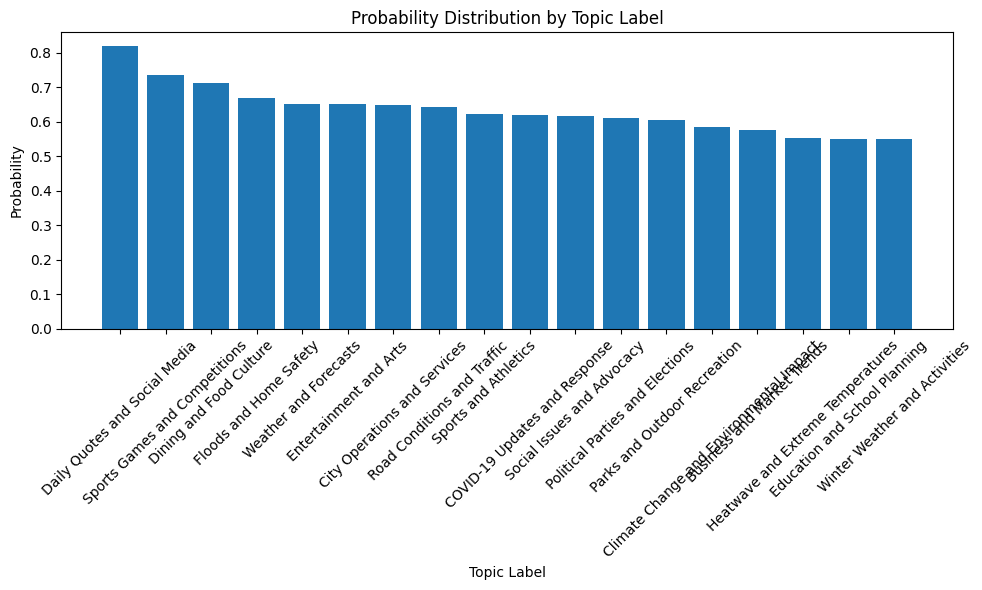

In [93]:
# Group the dataframe by topic label and calculate the mean probability
grouped_df = df.groupby('Topic Label')['Probability'].mean().reset_index()

# Sort the dataframe by descending probability
grouped_df = grouped_df.sort_values(by='Probability', ascending=False)

# Plotting the data
plt.figure(figsize=(10, 6))
plt.bar(grouped_df['Topic Label'], grouped_df['Probability'])
plt.xlabel('Topic Label')
plt.ylabel('Probability')
plt.title('Probability Distribution by Topic Label')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


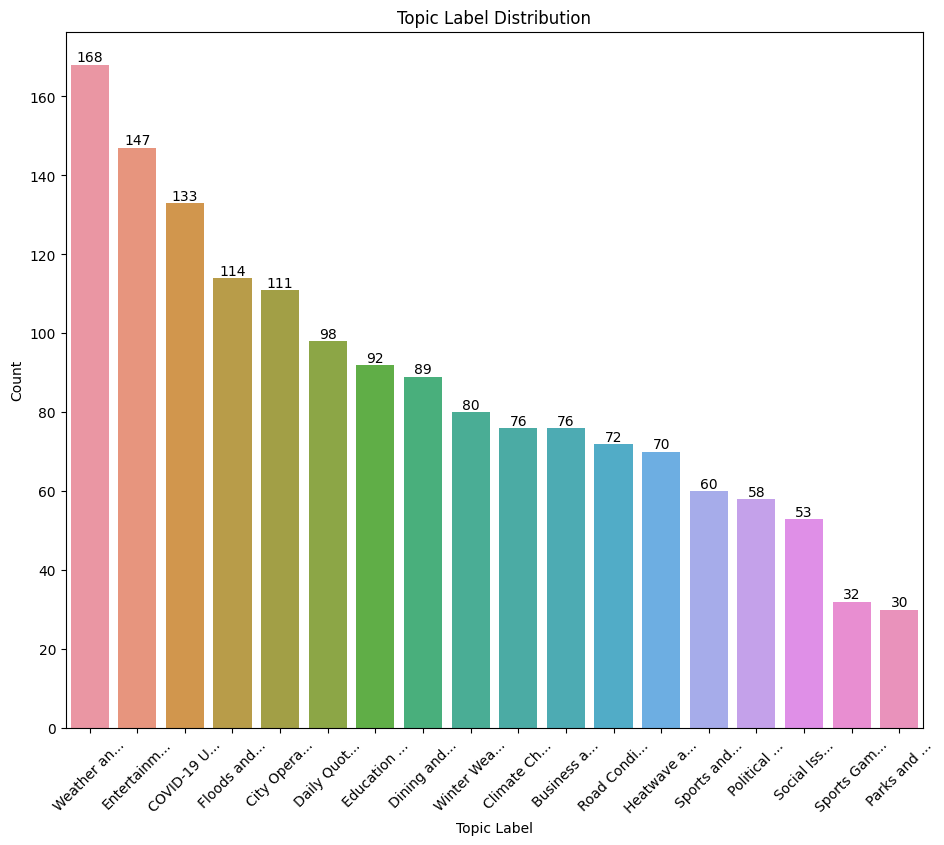

In [92]:
# Count the occurrences of each topic label
label_counts = df['Topic Label'].value_counts()

plt.figure(figsize=(10, 10))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.xlabel('Topic Label')
plt.ylabel('Count')
plt.title('Topic Label Distribution')
plt.xticks(rotation=45)
plt.tight_layout()

# Truncate the topic labels
plt.xticks(range(len(label_counts.index)), [label[:10] + '...' if len(label) > 10 else label for label in label_counts.index], rotation=45)
for i, count in enumerate(label_counts.values):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.show()